# Metadata Embedding Model


### Load Metadata

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from google.colab import drive

drive.mount('/content/drive')

train_metadata_path = '/content/drive/My Drive/Term 7/Computer Vision/Skin Cancer Detection/Datasets/train-metadata.csv'
test_metadata_path = '/content/drive/My Drive/Term 7/Computer Vision/Skin Cancer Detection/Datasets/test-metadata.csv'

# Load metadata and pre process the data
train_metadata = pd.read_csv(train_metadata_path)
test_metadata = pd.read_csv(test_metadata_path)
train_metadata.columns = train_metadata.columns.str.strip()
test_metadata.columns = test_metadata.columns.str.strip()

# Columns common to both train and test datasets
common_columns = [
    "isic_id", "patient_id", "age_approx", "sex", "anatom_site_general",
    "clin_size_long_diam_mm", "image_type", "tbp_tile_type", "tbp_lv_A",
    "tbp_lv_B", "tbp_lv_perimeterMM", "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt", "tbp_lv_symm_2axis",
    "tbp_lv_symm_2axis_angle", "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]

train_metadata = train_metadata[common_columns + ['target']].dropna()
test_metadata = test_metadata[common_columns].dropna()
train_metadata.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-9-41856e11bc7b>:16: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_metadata_path)


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_B,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,target
0,ISIC_0015670,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,26.922447,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0
1,ISIC_0015845,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,26.331000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0
2,ISIC_0015864,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,37.970460,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,0
3,ISIC_0015902,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,21.448144,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0
4,ISIC_0024200,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,26.464900,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,0


### Preprocessing Metadata

In [ ]:
categorical_columns = ['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    train_metadata[col] = le.fit_transform(train_metadata[col])
    test_metadata[col] = le.transform(test_metadata[col])
    label_encoders[col] = le

numerical_columns = [
    "age_approx", "clin_size_long_diam_mm", "tbp_lv_A", "tbp_lv_B",
    "tbp_lv_perimeterMM", "tbp_lv_radial_color_std_max", "tbp_lv_stdL",
    "tbp_lv_stdLExt", "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]

scaler = StandardScaler()
train_metadata[numerical_columns] = scaler.fit_transform(train_metadata[numerical_columns])
test_metadata[numerical_columns] = scaler.transform(test_metadata[numerical_columns])

In [ ]:
X = train_metadata.drop(columns=["isic_id", "patient_id", "target"])
y = train_metadata["target"]

# Convert data to numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)

# Create DataLoader objects
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 3820
Number of validation batches: 955


### Neural Network Model


In [ ]:
class MetadataNN(nn.Module):
    def __init__(self, input_dim):
        super(MetadataNN, self).__init__()

        # FC layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = MetadataNN(input_dim)

# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = loss_fn(outputs.squeeze(), batch_y.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0115
Epoch [2/10], Loss: 0.0069
Epoch [3/10], Loss: 0.0063
Epoch [4/10], Loss: 0.0059
Epoch [5/10], Loss: 0.0057
Epoch [6/10], Loss: 0.0056
Epoch [7/10], Loss: 0.0054
Epoch [8/10], Loss: 0.0053
Epoch [9/10], Loss: 0.0053
Epoch [10/10], Loss: 0.0052


### Evaluation


In [ ]:
model.eval()

with torch.no_grad():
    y_pred = []
    y_true = []

    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)

        # Get predictions
        predictions = torch.sigmoid(outputs)
        predicted_labels = (predictions >= 0.5).float()

        y_pred.extend(predicted_labels.numpy())
        y_true.extend(batch_y.numpy())

y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.9990
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Plot

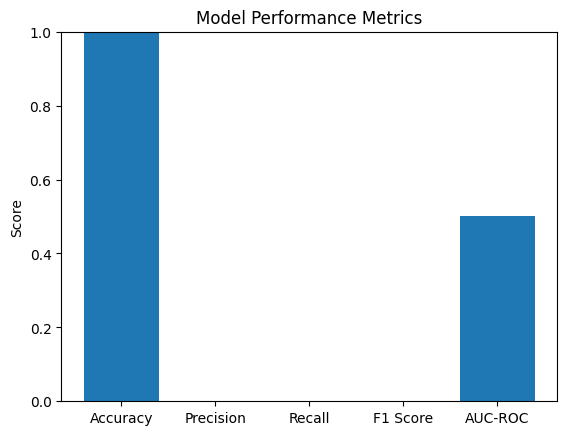

In [ ]:
import matplotlib.pyplot as plt

metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'AUC-ROC': roc_auc}
plt.bar(metrics.keys(), metrics.values())
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()